In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # plot patchwork
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # ggplot2 drawing


source("../../utils/figure_themes.r")


In [2]:
model_name <- "MultiClass_MLP"
cell_type <- "PBMC"

## Probabilities

In [3]:
# load in the probabilities
treatment_holdout_probabilities_path <- file.path(
    paste0(
        "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/probabilities.parquet"
    )
)
# read in the data from the parquet file
probabilities <- arrow::read_parquet(
    treatment_holdout_probabilities_path
)
head(probabilities,2)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,labels
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.1163489,0.4907182,0.3929329,2,1,train,TRUE,pyroptosis,2534673,PBMC,⋯,169,LPS,10.000_µg_per_ml,95.86607,128.3363,111,143,87,117,healthy
0.1103378,0.4905671,0.3990950,1,1,train,TRUE,healthy,1010528,PBMC,⋯,604,LPS_Nigericin,100.000_µg_per_ml_10.000_µM,244.81614,477.4955,258,489,233,466,pyroptosis


In [4]:
unique(probabilities$data_split)
unique(probabilities$shuffle)

[1] "train"             "validation"        "testing"          
[4] "treatment_holdout" "holdout"

[1]  TRUE FALSE

In [5]:
# # remove rows where shuffle is true
# probabilities <- probabilities[!grepl("TRUE", probabilities$shuffle),]

In [6]:
# replace label_true value 1 with Control
probabilities$label_true <- gsub("1", "Control", probabilities$label_true)
# replace label_true value 2 with pyroptosis
probabilities$label_true <- gsub("2", "Pyroptosis", probabilities$label_true)
# replace label_true value 0 with apoptosis
probabilities$label_true <- gsub("0", "Apoptosis", probabilities$label_true)

# replace label_pred value 1 with Control
probabilities$label_pred <- gsub("1", "Control", probabilities$label_pred)
# replace label_pred value 2 with pyroptosis
probabilities$label_pred <- gsub("2", "Pyroptosis", probabilities$label_pred)
# replace label_pred value 0 with apoptosis
probabilities$label_pred <- gsub("0", "Apoptosis", probabilities$label_pred)

# replace shuffled value TRUE with Shuffled
probabilities$shuffle <- gsub("TRUE", "Shuffled", probabilities$shuffle)
# replace shuffled value FALSE with Not Shuffled
probabilities$shuffle <- gsub("FALSE", "Not Shuffled", probabilities$shuffle)

# replace data_split value treatment_holdout with Treatment Holdout
probabilities$data_split <- gsub("treatment_holdout", "Treatment Holdout", probabilities$data_split)
# replace data_split value holdout with Holdout
probabilities$data_split <- gsub("holdout", "Holdout", probabilities$data_split)
# replace training value train with Training
probabilities$data_split <- gsub("train", "Training", probabilities$data_split)
# replace testing value test with Testing
probabilities$data_split <- gsub("testing", "Testing", probabilities$data_split)
# replace validation value validation with Validation
probabilities$data_split <- gsub("validation", "Validation", probabilities$data_split)


In [7]:
head(probabilities, 2)
unique(probabilities$shuffle)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,labels
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.1163489,0.4907182,0.3929329,Pyroptosis,Control,Training,Shuffled,pyroptosis,2534673,PBMC,⋯,169,LPS,10.000_µg_per_ml,95.86607,128.3363,111,143,87,117,healthy
0.1103378,0.4905671,0.3990950,Control,Control,Training,Shuffled,healthy,1010528,PBMC,⋯,604,LPS_Nigericin,100.000_µg_per_ml_10.000_µM,244.81614,477.4955,258,489,233,466,pyroptosis


[1] "Shuffled"     "Not Shuffled"

In [8]:
# change the label columns to be factors
probabilities$label_true <- factor(probabilities$label_true , levels = c(
    "Control", "Apoptosis", "Pyroptosis"
))
probabilities$label_pred <- factor(probabilities$label_pred , levels = c(
    "Pyroptosis", "Apoptosis", "Control"
))
# change the data_split column to be a factor
probabilities$data_split <- factor(probabilities$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# change the shuffled_data column to be a factor
probabilities$shuffle <- factor(probabilities$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))

# remove treatment holdout rows
probabilities <- probabilities[!grepl("Treatment Holdout", probabilities$data_split),]

Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.0056

Picking joint bandwidth of 0.00405

Picking joint bandwidth of 0.00408

Picking joint bandwidth of 0.00735

Picking joint bandwidth of 0.00974

Picking joint bandwidth of 0.0071

Picking joint bandwidth of 0.00745

Picking joint bandwidth of 0.0147

Picking joint bandwidth of 0.00562

Picking joint bandwidth of 0.00397

Picking joint bandwidth of 0.00401



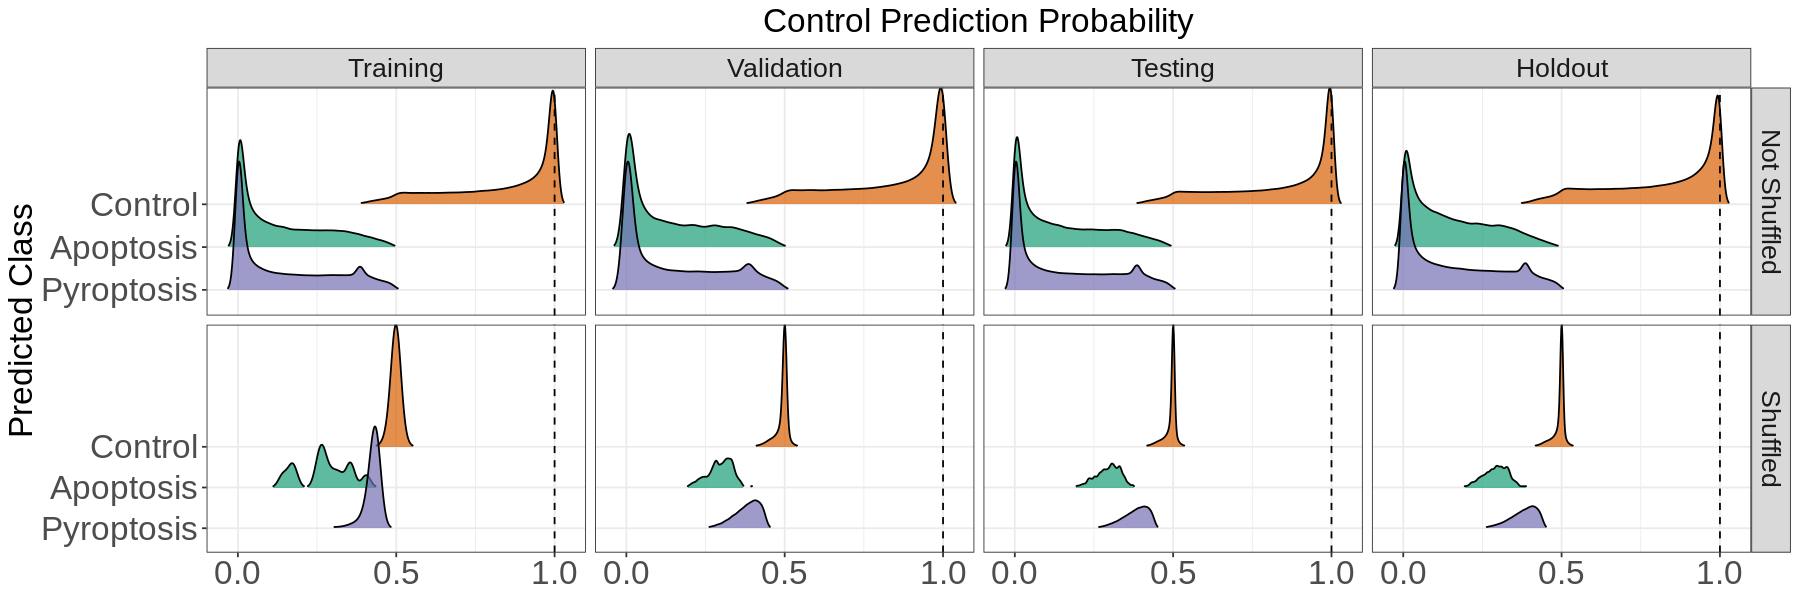

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.00805

Picking joint bandwidth of 0.0041

Picking joint bandwidth of 0.00312

Picking joint bandwidth of 0.00313



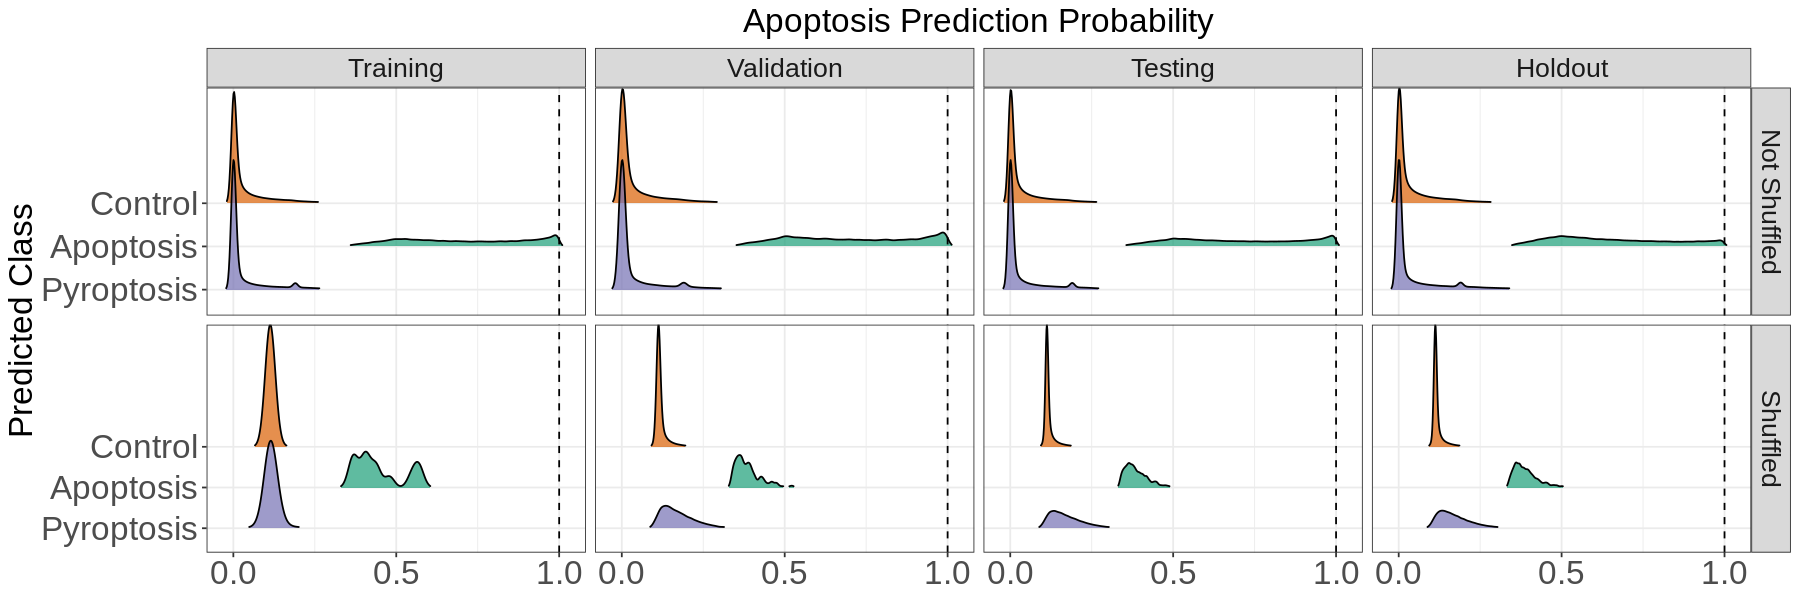

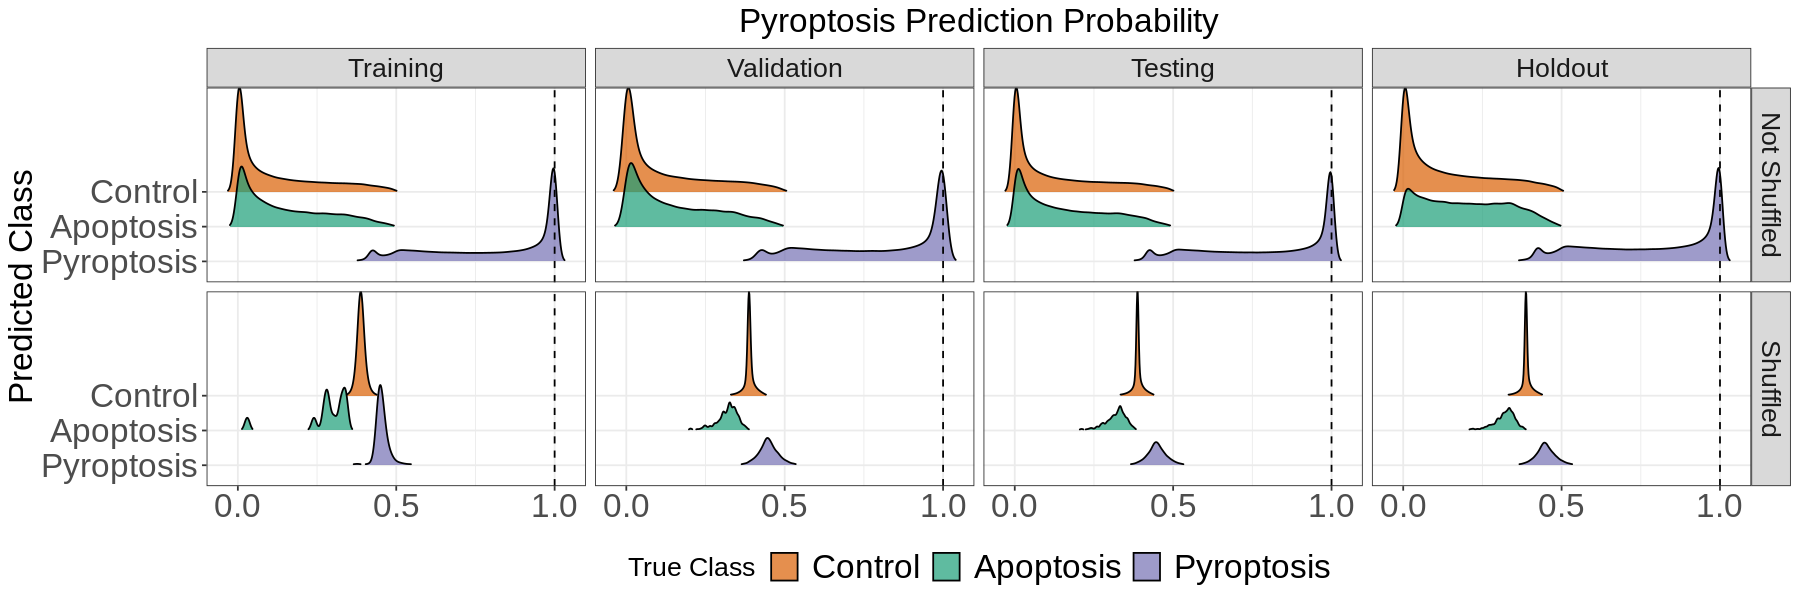

In [9]:
height <- 5
width <- 15
options(repr.plot.width = width, repr.plot.height = height)
ridge_plot_control <- (
    ggplot(probabilities, aes(x = control_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    # change color of the density ridges
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    

    + facet_grid(shuffle~data_split, scales = "free_y")
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(title = "Control Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # no legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # remove x axis label
    + theme(axis.title.x = element_blank())
)
ridge_plot_control


ridge_plot_apoptosis <- (
    ggplot(probabilities, aes(x = apoptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(shuffle~data_split, scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(title = "Apoptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # remove legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # remove x axis label   
    + theme(axis.title.x = element_blank())
)
ridge_plot_apoptosis

ridge_plot_pyroptosis <- (
    ggplot(probabilities, aes(x = pyroptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(shuffle~data_split, scales = "free_y")+ scale_x_continuous(breaks = seq(0, 1, 0.5))
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(title = "Pyroptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # make title larger
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label
    + theme(axis.title.x = element_blank())
    # add vertical line at 1 
    # change legend label order
    + guides(fill = guide_legend(reverse = TRUE))
)
ridge_plot_pyroptosis


### Patch the individual facet grids together for a figure sub-panel

Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.0056

Picking joint bandwidth of 0.00405

Picking joint bandwidth of 0.00408

Picking joint bandwidth of 0.00735

Picking joint bandwidth of 0.00974

Picking joint bandwidth of 0.0071

Picking joint bandwidth of 0.00745

Picking joint bandwidth of 0.0147

Picking joint bandwidth of 0.00562

Picking joint bandwidth of 0.00397

Picking joint bandwidth of 0.00401

Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.00805

Picking joint bandwidth of 0.0041

Picking joint bandwidth of 0.00312

Picking joint bandwidth of 0.00313

Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0106

Picking jo

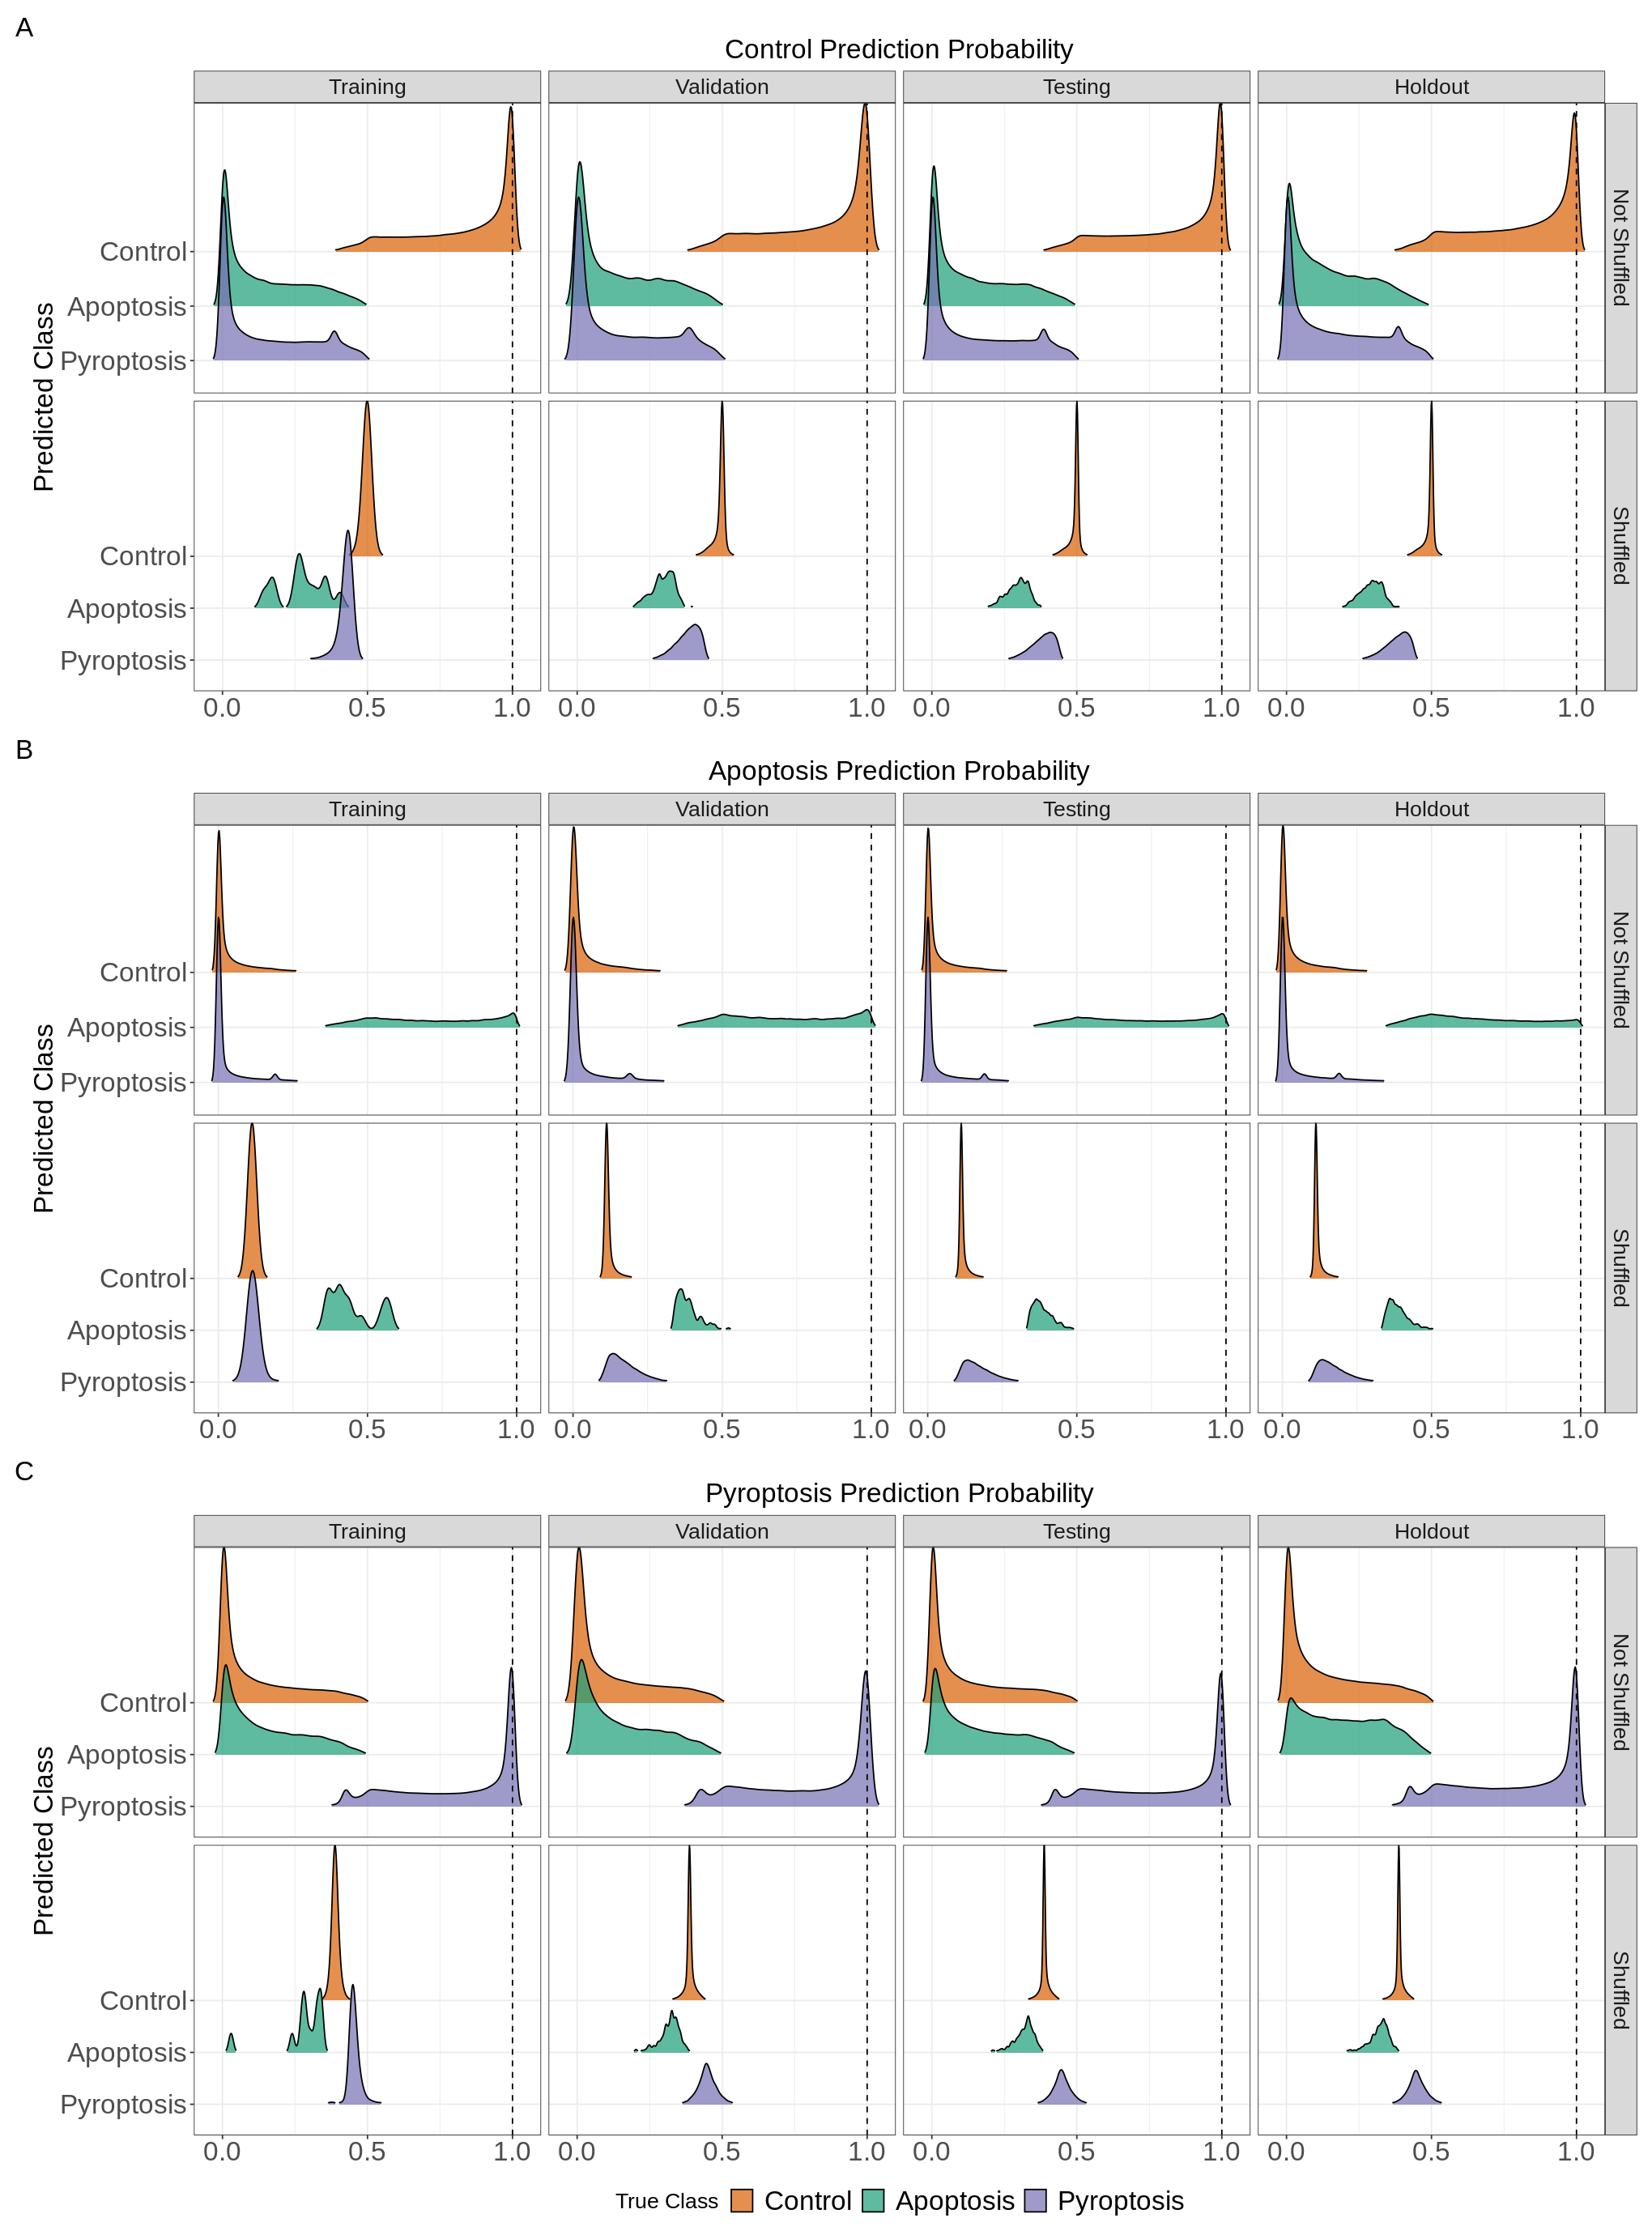

In [10]:
# patch the plots together via the patchwork package
layout <- c(
    area(t=1, b=2, l=1, r=1), # A
    area(t=3, b=4, l=1, r=1), # B
    area(t=5, b=6, l=1, r=1)  # C
)
# set plot size
width <- 17
height <- 23
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
fig5_probabilities <- (
    ridge_plot_control
    + ridge_plot_apoptosis
    + ridge_plot_pyroptosis
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = "A") &  theme(plot.tag = element_text(size = 20))
)
fig5_probabilities

# save the plot
ggsave(
    filename = paste0("../figures/","S9",".png"),
    plot = fig5_probabilities,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)